In [8]:
import requests
from bs4 import BeautifulSoup
import os
import time
import fitz  
import re
import json
import pandas as pd


BASE_URL = 'https://main.sci.gov.in'
SEARCH_URL = f'{BASE_URL}/judgments'
SCRAPED_PDF_FOLDER = 'scraped_judgments'


STRUCTURED_DATA_FOLDER = 'structured_output_scraped'
FINAL_DATASET_CSV = 'supreme_court_judgments_dataset.csv'


os.makedirs(SCRAPED_PDF_FOLDER, exist_ok=True)
os.makedirs(STRUCTURED_DATA_FOLDER, exist_ok=True)

print("Setup Complete. All libraries imported and folders created.")

Setup Complete. All libraries imported and folders created.


In [9]:
def scrape_indian_kanoon(search_url):
    
    print(f"Scraping PDFs from: {search_url}")
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 1.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        response = requests.get(search_url, headers=headers, timeout=30)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, 'html.parser')
        doc_links = soup.select('.result_title a')
        
        if not doc_links:
            print("No document links found. Please check the search URL.")
            return

        print(f"Found {len(doc_links)} judgments on this page.")

        for link in doc_links:
            
            doc_page_url = f"https://indiankanoon.org{link['href']}"
            
            doc_page_response = requests.get(doc_page_url, headers=headers)
            doc_soup = BeautifulSoup(doc_page_response.text, 'html.parser')
            
            pdf_form = doc_soup.select_one('form[action^="/docfragment/"]')
            if pdf_form:
               
                pdf_url = f"https://indiankanoon.org{pdf_form['action']}"
                
                file_name = os.path.join(SCRAPED_PDF_FOLDER, link['href'].split('/')[-2] + '.pdf')
                
                if not os.path.exists(file_name):
                    print(f"Downloading {file_name}...")
                    pdf_response = requests.get(pdf_url, headers=headers)
                    with open(file_name, 'wb') as f:
                        f.write(pdf_response.content)
                    time.sleep(1)
                else:
                    print(f"Skipping {file_name}, already downloaded.")

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

print("New scraper function defined for Indian Kanoon.")

New scraper function defined for Indian Kanoon.


In [10]:
search_results_url = "https://indiankanoon.org/search/?formInput=supreme+court+of+india+2024"

if "PASTE_THE_URL" in search_results_url:
    print("Please replace 'PASTE_THE_URL_FROM_YOUR_BROWSER_HERE' with the actual URL from Indian Kanoon.")
else:
    scrape_indian_kanoon(search_results_url)
    print("\nScraping complete!")

Scraping PDFs from: https://indiankanoon.org/search/?formInput=supreme+court+of+india+2024
Found 10 judgments on this page.

Scraping complete!


In [12]:
search_results_url = "https://indiankanoon.org/search/?formInput=supreme%20court%20of%20india%202024&pagenum=9"

if "PASTE_THE_URL" in search_results_url:
    print("Please replace 'PASTE_THE_URL_FROM_YOUR_BROWSER_HERE' with the actual URL from Indian Kanoon.")
else:
    scrape_indian_kanoon(search_results_url)
    print("\nScraping complete!")

Scraping PDFs from: https://indiankanoon.org/search/?formInput=supreme%20court%20of%20india%202024&pagenum=9
Found 10 judgments on this page.

Scraping complete!


In [13]:
def extract_metadata(full_text):
    metadata = {
        'court': 'Not Found', 'case_number': 'Not Found',
        'petitioner': 'Not Found', 'respondent': 'Not Found',
        'judgment_date': 'Not Found'
    }
    court_match = re.search(r"IN THE (SUPREME COURT OF INDIA|HIGH COURT OF [A-Z ]+)", full_text, re.IGNORECASE)
    if court_match: metadata['court'] = court_match.group(0).strip()
    case_no_match = re.search(r"([A-Z\.\s]+\s?(?:NO|Number)\.\s\d+\sOF\s\d{4})", full_text, re.IGNORECASE)
    if case_no_match: metadata['case_number'] = case_no_match.group(1).strip()
    parties_match = re.search(r"([A-Za-z\s\.,&]+)\s*\.{3,}\s*(?:Petitioner|Appellant)\(s\)\s*VERSUS\s*([A-Za-z\s\.,&]+)\s*\.{3,}\s*(?:Respondent)\(s\)", full_text, re.DOTALL | re.IGNORECASE)
    if parties_match:
        metadata['petitioner'] = parties_match.group(1).strip().replace('\n', ' ')
        metadata['respondent'] = parties_match.group(2).strip().replace('\n', ' ')
    date_match = re.search(r"(?:Date of judgment|Dated|Decided on):?\s*(\d{1,2}[\.\-/]\d{1,2}[\.\-/]\d{4})", full_text, re.IGNORECASE)
    if date_match: metadata['judgment_date'] = date_match.group(1).strip()
    return metadata

def extract_sections(full_text):
    
    extracted_sections = {}
    section_markers = {
        'facts': [r"FACTS OF THE CASE", r"BRIEF FACTS", r"BACKGROUND"],
        'arguments_petitioner': [r"ARGUMENTS OF THE PETITIONER", r"SUBMISSIONS ON BEHALF OF THE PETITIONER"],
        'arguments_respondent': [r"ARGUMENTS OF THE RESPONDENT", r"SUBMISSIONS ON BEHALF OF THE RESPONDENT"],
        'ratio': [r"RATIO DECIDENDI", r"REASONING OF THE COURT", r"ANALYSIS AND FINDINGS"],
        'conclusion': [r"CONCLUSION", r"ORDER"]
    }
    all_markers_pattern = '|'.join([item for sublist in section_markers.values() for item in sublist])
    matches = list(re.finditer(all_markers_pattern, full_text, re.IGNORECASE))
    if not matches:
        extracted_sections['full_text'] = full_text
        return extracted_sections
    for i, current_match in enumerate(matches):
        section_start_pos = current_match.start()
        current_heading = current_match.group(0).upper()
        current_section_name = "unknown_section"
        for name, patterns in section_markers.items():
            if any(pattern in current_heading for pattern in patterns):
                current_section_name = name
                break
        section_end_pos = matches[i + 1].start() if i + 1 < len(matches) else len(full_text)
        section_text = full_text[section_start_pos:section_end_pos].strip()
        extracted_sections[current_section_name] = section_text
    return extracted_sections

print("PDF parsing functions defined.")

PDF parsing functions defined.


In [14]:
all_judgments_data = []
pdf_files = [f for f in os.listdir(SCRAPED_PDF_FOLDER) if f.endswith('.pdf')]

print(f"Starting to process {len(pdf_files)} downloaded PDFs...")

for pdf_file in pdf_files:
    file_path = os.path.join(SCRAPED_PDF_FOLDER, pdf_file)
    try:
        full_text = ""
        with fitz.open(file_path) as doc:
            for page in doc:
                full_text += page.get_text()

        if len(full_text) < 200:
            print(f"-> Skipping {pdf_file}: Likely scanned or empty.")
            continue
        
        metadata = extract_metadata(full_text)
        sections = extract_sections(full_text)
        
       
        record = {
            'source_file': pdf_file,
            **metadata, 
            **sections  
        }
        all_judgments_data.append(record)
        print(f"-> Successfully processed {pdf_file}")

    except Exception as e:
        print(f"-> Error processing {pdf_file}: {e}")
        
print(f"\nProcessing complete. Successfully structured {len(all_judgments_data)} documents.")

Starting to process 30 downloaded PDFs...
-> Successfully processed 123466668.pdf
-> Successfully processed 133672468.pdf
-> Successfully processed 136027261.pdf
-> Successfully processed 138624665.pdf
-> Successfully processed 141993488.pdf
-> Successfully processed 143469731.pdf
-> Successfully processed 145215254.pdf
-> Successfully processed 158138659.pdf
-> Successfully processed 162512169.pdf
-> Successfully processed 163737191.pdf
-> Successfully processed 164045627.pdf
-> Successfully processed 167792058.pdf
-> Successfully processed 168119088.pdf
-> Successfully processed 169047924.pdf
-> Successfully processed 172290164.pdf
-> Successfully processed 187799359.pdf
-> Successfully processed 191312981.pdf
-> Successfully processed 24526443.pdf
-> Successfully processed 34350791.pdf
-> Successfully processed 34954879.pdf
-> Successfully processed 39962246.pdf
-> Successfully processed 40000916.pdf
-> Successfully processed 62727113.pdf
-> Successfully processed 6825021.pdf
-> Suc

In [16]:
df = pd.DataFrame(all_judgments_data)

desired_order = [
    'source_file', 'judgment_date', 'court', 'case_number', 'petitioner', 'respondent',
    'facts', 'arguments_petitioner', 'arguments_respondent', 'ratio', 'conclusion', 'full_text'
]
final_columns = [col for col in desired_order if col in df.columns]
df = df[final_columns]

df.to_csv(FINAL_DATASET_CSV, index=False)

print(f"Dataset successfully created and saved to '{FINAL_DATASET_CSV}'")
print("Here's a preview of your final dataset:")
df.head(30)

Dataset successfully created and saved to 'supreme_court_judgments_dataset.csv'
Here's a preview of your final dataset:


,source_file,judgment_date,court,case_number,petitioner,respondent,facts,ratio,conclusion
0,123466668.pdf,06.03.2020,IN THE HIGH COURT OF PUNJAB AND HARYANA,facts are being taken from CWP No.\n14546 of 2024,Not Found,Not Found,background of\nthe facts as well as law which ...,NaN,order be placed on the file of connected\ncase...
1,133672468.pdf,31.08.2016,IN THE SUPREME COURT OF INDIA,Not Found,Not Found,Not Found,NaN,NaN,orders in MISCELLANEOUS APPLICATION\n………..D.NO...
2,136027261.pdf,08.03.2017,Not Found,. The said issue came to be decided by the Div...,Not Found,Not Found,Background\n1. The Government of Haryana vide ...,NaN,order be placed on the files of connected\ncas...
3,138624665.pdf,17.05.2024,IN THE SUPREME COURT OF INDIA,Not Found,Not Found,Not Found,NaN,NaN,orders in M.A.No.626/2020 in D.No.8542/2019 et...
4,141993488.pdf,24.02.2023,IN THE SUPREME COURT OF INDIA,of this Court in C.A. No. 11857\nof 2016,Not Found,Not Found,NaN,NaN,"order.\n6. All pending applications, if any, a..."
5,143469731.pdf,08.03.2017,Not Found,. The said issue came to be decided by the Div...,Not Found,Not Found,Background\n1. The Government of Haryana vide ...,NaN,order be placed on the files of connected\ncas...
6,145215254.pdf,06.03.2020,IN THE HIGH COURT OF PUNJAB AND HARYANA,facts are being taken from CWP No.\n14546 of 2024,Not Found,Not Found,background of\nthe facts as well as law which ...,NaN,order be placed on the file of connected\ncase...
7,158138659.pdf,08.03.2017,Not Found,. The said issue came to be decided by the Div...,Not Found,Not Found,Background\n1. The Government of Haryana vide ...,NaN,order be placed on the files of connected\ncas...
8,162512169.pdf,08.03.2017,Not Found,. The said issue came to be decided by the Div...,Not Found,Not Found,Background\n1. The Government of Haryana vide ...,NaN,order be placed on the files of connected\ncas...
9,163737191.pdf,11.04.2023,Not Found,No. 4722 of 2021,Not Found,Not Found,brief facts of this case are that the applican...,NaN,"order as to costs.\n22. Pending MAs, if any, s..."


### Data Cleaning and Preprocessing

In [17]:
import pandas as pd
import numpy as np
df = pd.read_csv('supreme_court_judgments_dataset.csv')

In [18]:
df.replace('Not Found', np.nan, inplace=True)
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
source_file       0
judgment_date     2
court            14
case_number       3
petitioner       30
respondent       30
facts             8
ratio            29
conclusion        0
dtype: int64


In [19]:
df['court'] = df['court'].str.strip()
df['court'] = df['court'].str.replace('IN THE HIGH COURT OF JUDIC', 'IN THE HIGH COURT OF JUDICATURE', case=False)

print("\nCleaned Court Names:")
print(df['court'].value_counts())


Cleaned Court Names:
court
IN THE HIGH COURT OF PUNJAB AND HARYANA          8
IN THE SUPREME COURT OF INDIA                    5
IN THE HIGH COURT OF JUDICATUREATURE AT BOMBA    1
IN THE HIGH COURT OF J                           1
IN THE HIGH COURT OF JUDICATURE                  1
Name: count, dtype: int64


In [20]:
df['judgment_date'] = pd.to_datetime(df['judgment_date'], dayfirst=True, errors='coerce')

print("\nData types after conversion:")
print(df.dtypes)


Data types after conversion:
source_file              object
judgment_date    datetime64[ns]
court                    object
case_number              object
petitioner              float64
respondent              float64
facts                    object
ratio                    object
conclusion               object
dtype: object


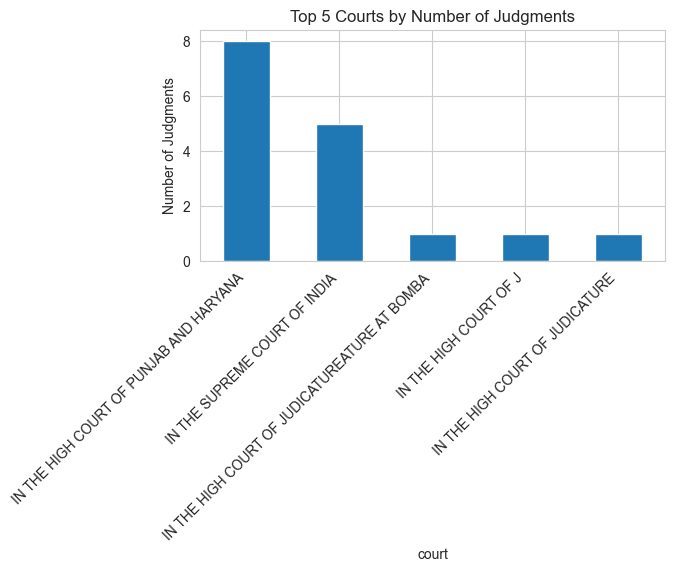

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

plt.figure(figsize=(6, 3))
df['court'].value_counts().nlargest(5).plot(kind='bar')
plt.title('Top 5 Courts by Number of Judgments')
plt.ylabel('Number of Judgments')
plt.xticks(rotation=45, ha='right')
plt.show()

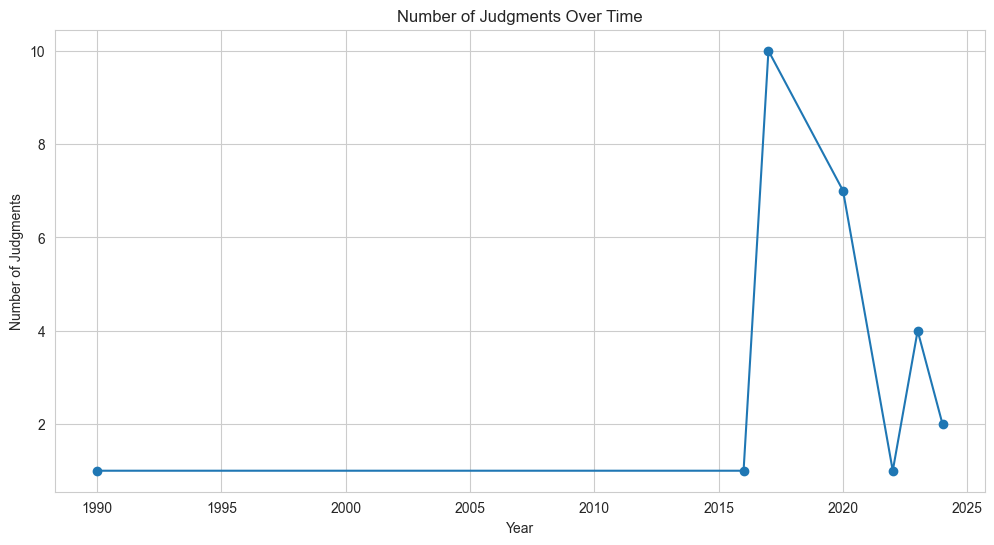

In [25]:
df['judgment_year'] = df['judgment_date'].dt.year

plt.figure(figsize=(12, 6))
df.groupby('judgment_year')['source_file'].count().plot(kind='line', marker='o')
plt.title('Number of Judgments Over Time')
plt.ylabel('Number of Judgments')
plt.xlabel('Year')
plt.show()